In [1]:
import os
import scanpy as sc
import pandas as pd
import scvi
import numpy as np
import pyranges as pr

/opt/modules/i12g/anaconda/envs/scooby_reproducibility/lib/python3.9/site-packages/docrep/decorators.py:43: SyntaxWarning: 'param_size_factor_key_expr' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)
/opt/modules/i12g/anaconda/envs/scooby_reproducibility/lib/python3.9/site-packages/docrep/decorators.py:43: SyntaxWarning: 'param_size_factor_key_acc' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)


In [2]:
from scooby.utils.transcriptome import Transcriptome
import polars as pl

## Read adata

In [14]:
data_path = "/data/ceph/hdd/project/node_08/QNA/scborzoi/submission_data"

In [7]:
adata = sc.read(
    os.path.join(data_path, 'bmmc_multiome_multivi_neurips21_curated_new_palantir_fixed.h5ad'))

## Check which genes overlap with val/test genes

In [8]:
gtf_file = os.path.join(data_path, 'gencode.v32.annotation.gtf')
bed_file = os.path.join(data_path, 'scooby_training_data', 'sequences.bed')
fasta_file = os.path.join(data_path, 'scooby_training_data','genome_human.fa')

In [9]:
# gtf file
gtf = pr.read_gtf(gtf_file)

In [10]:
genes = gtf[gtf.Feature=='gene'].df

In [11]:
# read sequences
sequences = pr.read_bed(bed_file)

In [12]:
genes = pr.PyRanges(genes)

In [63]:
# sequences that are not in test or train fold
sequences_val = sequences[sequences.Name.isin(['fold4'])]
sequences_test = sequences[sequences.Name.isin(['fold3'])]
sequences_train = sequences[~sequences.Name.isin(['fold4', 'fold3'])]

In [64]:
val_genes = genes.overlap(sequences_val, invert=False)
test_genes = genes.overlap(sequences_test, invert=False)
train_genes = genes.overlap(sequences_train, invert=False)

In [65]:
print(len(val_genes))
print(len(test_genes))
print(len(train_genes))

6671
6276
44988


In [67]:
# make sure that they really do not overlap with train set
val_genes = val_genes.overlap(sequences_train, invert=True)
# make sure that they really do not overlap with train set and val set
test_genes = test_genes.overlap(sequences_train, invert=True).overlap(sequences_val, invert=True)
# make sure that they really do not overlap with val and test set
train_genes = train_genes.overlap(sequences_test, invert=True).overlap(sequences_val, invert=True)

In [68]:
print(len(val_genes))
print(len(test_genes))
print(len(train_genes))

6663
6261
44969


In [69]:
# drop duplicated gene names 
val_genes = val_genes.df.drop_duplicates(subset='gene_name')
test_genes = test_genes.df.drop_duplicates(subset='gene_name')
train_genes = train_genes.df.drop_duplicates(subset='gene_name')

In [70]:
# restrict to chromosomes
val_genes = val_genes[val_genes.Chromosome.str.contains('chr')]
test_genes = test_genes[test_genes.Chromosome.str.contains('chr')]
train_genes = train_genes[train_genes.Chromosome.str.contains('chr')]

In [71]:
print(len(val_genes))
print(len(test_genes))
print(len(train_genes))

6549
6160
44106


In [72]:
# include genes in adata
val_genes = val_genes[val_genes.gene_name.isin(adata.var.index)]
test_genes = test_genes[test_genes.gene_name.isin(adata.var.index)]
train_genes = train_genes[train_genes.gene_name.isin(adata.var.index)]

In [73]:
print(len(val_genes))
print(len(test_genes))
print(len(train_genes))

2918
2551
19806


In [74]:
val_genes.to_csv(os.path.join(data_path, 'scooby_training_data', 'val_genes.csv'))
test_genes.to_csv(os.path.join(data_path, 'scooby_training_data', 'test_genes.csv'))
train_genes.to_csv(os.path.join(data_path, 'scooby_training_data', 'train_genes.csv'))

### Write genes sequences

In [75]:
val_genes = pd.read_csv(os.path.join(data_path, 'scooby_training_data', 'val_genes.csv'), index_col=0)
test_genes = pd.read_csv(os.path.join(data_path, 'scooby_training_data', 'test_genes.csv'), index_col=0)
train_genes = pd.read_csv(os.path.join(data_path, 'scooby_training_data', 'train_genes.csv'), index_col=0)

In [76]:
transcriptome = Transcriptome(gtf_file)

In [77]:
context_length = 524288

In [78]:
def get_gene_span(transcriptome, gene_name):
    gene = transcriptome.genes[gene_name]
    center_pos = gene.span()[0] + (gene.span()[1] - gene.span()[0])//2 #middle
    start = center_pos - context_length // 2
    chrom = gene.chrom
    seq_out_start = start + (context_length-(6144*32))/2
    seq_out_len = 6144*32
    return     {'Chromosome': chrom, 'Start': int(seq_out_start), 'End': int(seq_out_start + seq_out_len), 'gene_name': gene_name, 'Strand': gene.strand}

In [79]:
val_bed_df = pd.DataFrame([get_gene_span(transcriptome, gene_name) for gene_name in val_genes.gene_name])

val_bed_df = pl.DataFrame(val_bed_df)

print(val_bed_df.shape)
val_bed_df.write_csv(os.path.join(data_path, 'scooby_training_data', 'val_gene_sequences.csv'), separator="\t", include_header=False)

(2918, 5)


In [80]:
test_bed_df = pd.DataFrame([get_gene_span(transcriptome, gene_name) for gene_name in test_genes.gene_name])
test_bed_df = pl.DataFrame(test_bed_df)
print(test_bed_df.shape)
test_bed_df.write_csv(os.path.join(data_path, 'scooby_training_data', 'test_gene_sequences.csv'), separator="\t", include_header=False)

(2551, 5)


In [81]:
train_bed_df = pd.DataFrame([get_gene_span(transcriptome, gene_name) for gene_name in train_genes.gene_name])
train_bed_df = pl.DataFrame(train_bed_df)
print(train_bed_df.shape)
train_bed_df.write_csv(os.path.join(data_path,'scooby_training_data', 'train_gene_sequences.csv'), separator="\t", include_header=False)

(19806, 5)


In [82]:
pl.concat([train_bed_df, val_bed_df,test_bed_df]).write_csv(os.path.join(data_path,'scooby_training_data', 'train_val_test_gene_sequences.csv'), separator="\t", include_header=False)

## Check which peaks overlap

In [83]:
adata_atac = adata[:, adata.var.feature_types=='ATAC']

In [84]:
adata_atac.var[['Chromosome', 'Start', 'End']] = adata_atac.var_names.to_series().str.split(':|-', regex=True, expand=True)

/scratch/tmp/martensl/ipykernel_3755919/741491573.py:1: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata_atac.var[['Chromosome', 'Start', 'End']] = adata_atac.var_names.to_series().str.split(':|-', regex=True, expand=True)


In [85]:
adata_atac.var['peak_name'] = adata_atac.var_names

In [86]:
peaks = pr.PyRanges(adata_atac.var)

In [87]:
# sequences that are not in test or train fold
sequences_val = sequences[sequences.Name.isin(['fold4'])]
sequences_test = sequences[sequences.Name.isin(['fold3'])]
sequences_train = sequences[~sequences.Name.isin(['fold4', 'fold3'])]

In [88]:
val_peaks = peaks.overlap(sequences_val, invert=False)
test_peaks = peaks.overlap(sequences_test, invert=False)

In [89]:
print(len(val_peaks))
print(len(test_peaks))

15029
13012


In [90]:
# make sure that they really do not overlap with train set
val_peaks = val_peaks.overlap(sequences_train, invert=True)
# make sure that they really do not overlap with train set and val set
test_peaks = test_peaks.overlap(sequences_train, invert=True).overlap(sequences_val, invert=True)

In [91]:
print(len(val_peaks))
print(len(test_peaks))

15029
13012


In [92]:
# restrict to chromosomes
val_peaks = val_peaks[val_peaks.Chromosome.str.contains('chr')]
test_peaks = test_peaks[test_peaks.Chromosome.str.contains('chr')]

In [93]:
print(len(val_peaks))
print(len(test_peaks))

15029
13012


In [94]:
val_peaks.to_csv(os.path.join(data_path, 'scooby_training_data', 'val_peaks.csv'))
test_peaks.to_csv(os.path.join(data_path, 'scooby_training_data', 'test_peaks.csv'))

## Run MultiVI on the filtered mudata

In [13]:
import scvi
import pandas as pd
import anndata as ad
from lightning.pytorch.loggers import WandbLogger
import wandb
import torch

In [15]:
val_genes = pd.read_csv(os.path.join(data_path, 'scooby_training_data', 'val_genes.csv'), index_col=0)
test_genes = pd.read_csv(os.path.join(data_path, 'scooby_training_data', 'test_genes.csv'), index_col=0)

In [16]:
val_peaks = pd.read_csv(os.path.join(data_path, 'scooby_training_data', 'val_peaks.csv'))
test_peaks = pd.read_csv(os.path.join(data_path, 'scooby_training_data', 'test_peaks.csv'))

In [17]:
adata_rna = adata[:, adata.var.feature_types=='GEX']

In [18]:
adata_atac = adata[:, adata.var.feature_types=='ATAC']

In [19]:
adata_rna_train = adata_rna[:, (~adata_rna.var_names.isin(val_genes.gene_name.to_list() + test_genes.gene_name.to_list()))].to_memory().copy()

In [20]:
adata_rna_train.X = adata_rna_train.layers['counts'].copy()

In [21]:
adata_atac_train = adata_atac[:, (~adata_atac.var_names.isin(val_peaks.peak_name.to_list() + test_peaks.peak_name.to_list()))].to_memory().copy()

In [22]:
(adata_atac_train.layers['counts'].data == 1).sum()/(adata_atac_train.layers['counts'].data == 2).sum()

np.float64(0.1899514679783804)

In [23]:
scvi.data.reads_to_fragments(adata_atac_train, read_layer='counts')

In [24]:
adata_atac_train.X = adata_atac_train.layers['fragments'].copy()

In [25]:
adata_train = ad.concat([adata_rna_train, adata_atac_train], axis=1)

In [26]:
adata_train.obs = adata_train.obs.join(adata.obs)

In [27]:
print(adata_train.shape)
sc.pp.filter_genes(adata_train, min_cells=int(adata_train.shape[0] * 0.01))
print(adata_train.shape)


(63683, 108609)
(63683, 55942)


In [28]:
wandb_logger = WandbLogger(project="neurips", entity='lauradm')

In [29]:
scvi.external.POISSONMULTIVI.setup_anndata(adata_train, batch_key='batch')

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [30]:
model = scvi.external.POISSONMULTIVI(
    adata_train,
    n_genes=(adata_train.var["feature_types"] == "GEX").sum(),
    n_regions=(adata_train.var["feature_types"] == "ATAC").sum(),
    fully_paired=True, 
)
model.view_anndata_setup()

/opt/modules/i12g/anaconda/envs/scooby_reproducibility/lib/python3.9/site-packages/torch/nn/init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Anndata setup with scvi-tools version 1.1.3.

Setup via `POISSONMULTIVI.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'batch',
│   'size_factor_key_expr': None,
│   'size_factor_key_acc': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None,
│   'protein_expression_obsm_key': None,
│   'protein_names_uns_key': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │  13   │
│         n_cells          │ 63683 │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │   1   │
│          n_vars          │ 55942 │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                  batch State Registry                   
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃  Source Location   ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['batch'] │    s1d1    │          0          │
│                    │    s1d2    │          1          │
│                    │    s1d3    │          2          │
│                    │    s2d1    │          3          │
│                    │    s2d4    │          4          │
│                    │    s2d5    │          5          │
│                    │    s3d3    │          6          │
│                    │    s3d6    │          7          │
│                    │    s3d7    │          8          │
│                    │   s3d10    │          9          │
│                    │    s4d1    │         10          │
│                    │    s4d8    │         11          │
│                    │    s4d9    │         12          │
└────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

                  batch State Registry                   
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃  Source Location   ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['batch'] │    s1d1    │          0          │
│                    │    s1d2    │          1          │
│                    │    s1d3    │          2          │
│                    │    s2d1    │          3          │
│                    │    s2d4    │          4          │
│                    │    s2d5    │          5          │
│                    │    s3d3    │          6          │
│                    │    s3d6    │          7          │
│                    │    s3d7    │          8          │
│                    │   s3d10    │          9          │
│                    │    s4d1    │         10          │
│                    │    s4d8    │         11          │
│                    │    s4d9    │         12          │
└────────────────────┴────────────┴─────────────────────┘

In [31]:
model.module

POISSONMULTIVAE(
  (z_encoder_expression): Encoder(
    (encoder): FCLayers(
      (fc_layers): Sequential(
        (Layer 0): Sequential(
          (0): Linear(in_features=8708, out_features=217, bias=True)
          (1): None
          (2): LayerNorm((217,), eps=1e-05, elementwise_affine=False)
          (3): LeakyReLU(negative_slope=0.01)
          (4): Dropout(p=0.1, inplace=False)
        )
        (Layer 1): Sequential(
          (0): Linear(in_features=217, out_features=217, bias=True)
          (1): None
          (2): LayerNorm((217,), eps=1e-05, elementwise_affine=False)
          (3): LeakyReLU(negative_slope=0.01)
          (4): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (mean_encoder): Linear(in_features=217, out_features=14, bias=True)
    (var_encoder): Linear(in_features=217, out_features=14, bias=True)
  )
  (l_encoder_expression): LibrarySizeEncoder(
    (px_decoder): FCLayers(
      (fc_layers): Sequential(
        (Layer 0): Sequential(
          (0):

In [108]:
model.train(accelerator='gpu', adversarial_mixing=False, logger=wandb_logger)

/scratch/tmp/hingerl/ipykernel_830987/3717432196.py:1: DeprecationWarning: `save_best` is deprecated in v1.2 and will be removed in v1.3. Please use `enable_checkpointing` instead. See https://github.com/scverse/scvi-tools/issues/2568 for more details.
  model.train(accelerator='gpu', adversarial_mixing=False, logger=wandb_logger)
/opt/modules/i12g/anaconda/envs/scvi-tools-1/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/modules/i12g/anaconda/envs/scvi-tools-1/lib/pyt ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/modules/i12g/anaconda/envs/scvi-tools-1/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is avail

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/opt/modules/i12g/anaconda/envs/scvi-tools-1/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/opt/modules/i12g/anaconda/envs/scvi-tools-1/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 120/500:  24%|██▍       | 120/500 [22:05<1:09:58, 11.05s/it, v_num=ns3g, train_loss_step=9.67e+3, train_loss_epoch=1.01e+4]
Monitored metric reconstruction_loss_validation did not improve in the last 50 records. Best score: 10299.841. Signaling Trainer to stop.


In [109]:
model.save(os.path.join(data_path, 'scooby_training_data','neurips_poissonmultivi_corrected_fixed'), save_anndata=True, overwrite=True)

## Create embedding

In [7]:
model = scvi.external.POISSONMULTIVI.load(os.path.join(data_path, 'scooby_training_data','neurips_poissonmultivi_corrected_fixed'))

INFO     File                                                                                                      
         /s/project/QNA/scborzoi/neurips_bone_marrow/snapatac/anndata/neurips_poissonmultivi_corrected_fixed/model.
         pt already downloaded                                                                                     


/opt/modules/i12g/anaconda/envs/scvi-tools-1/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/modules/i12g/anaconda/envs/scvi-tools-1/lib/pyt ...
/opt/modules/i12g/anaconda/envs/scvi-tools-1/lib/python3.12/site-packages/torch/nn/init.py:452: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


In [8]:
adata_train = model.adata.copy()

In [61]:
X_emb = model.get_latent_representation()

In [62]:
adata_train.obsm['X_poisson_multivi'] = X_emb
adata.obsm['X_poisson_multivi'] = X_emb

/scratch/tmp/martensl/ipykernel_116913/3371533580.py:2: ImplicitModificationWarning: Setting element `.obsm['X_poisson_multivi']` of view, initializing view as actual.
  adata.obsm['X_poisson_multivi'] = X_emb


In [63]:
sc.pp.neighbors(adata, use_rep='X_poisson_multivi')

In [64]:
sc.tl.umap(adata)

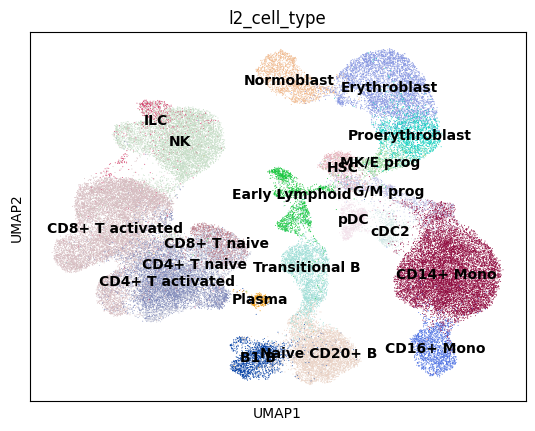

In [65]:
sc.pl.umap(adata, color='l2_cell_type', legend_loc='on data')

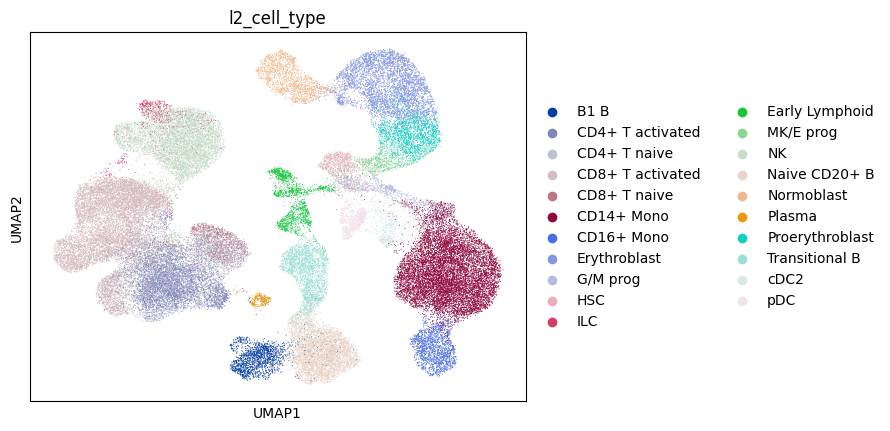

In [121]:
sc.pl.umap(adata, color = 'l2_cell_type')

In [66]:
adata.write(os.path.join(data_path,  'bmmc_multiome_multivi_neurips21_curated_new_palantir_fixed.h5ad'))

# Save embedding and neighborhood graph

In [125]:
embedding = pd.DataFrame({'embedding':list(adata_train.obsm['X_poisson_multivi']), 'obs_names': adata_train.obs.index})

In [126]:
embedding.to_parquet(os.path.join(data_path, 'scooby_training_data', 'embedding_no_val_genes_new.pq'))

In [128]:
sc.pp.neighbors(adata_train, use_rep='X_poisson_multivi', n_neighbors=100)

In [ ]:
scipy.sparse.save_npz(os.path.join(data_path, 'scooby_training_data', 'neighbors_100_no_val_genes_new.npz'), 
                      adata_train.obsp['distances'])

### Save new embedding to anndata

In [130]:
embedding = pd.read_parquet(os.path.join(data_path, 'scooby_training_data', 'embedding_no_val_genes_new.pq'))

In [134]:
adata.obsm['X_poisson_multivi'] = np.vstack(embedding.set_index("obs_names").loc[adata.obs_names, 'embedding'].values)

In [135]:
adata.write(os.path.join(data_path, 'bmmc_multiome_multivi_neurips21_curated_new_palantir_fixed.h5ad'))

## Write cell_type_index

In [137]:
cellindex = [
    {'celltype': cell_type, 
     'cellindex': list(np.where(adata.obs.l2_cell_type == cell_type)[0])} for cell_type in adata.obs.l2_cell_type.unique()
]

In [138]:
pd.DataFrame(cellindex).to_parquet(os.path.join(data_path,'scooby_training_data', 'celltype_fixed.pq'))

# Run diffussion pseudotime

In [97]:
adata = sc.read_h5ad(os.path.join(data_path, 'bmmc_multiome_multivi_neurips21_curated_new_palantir_fixed.h5ad'))

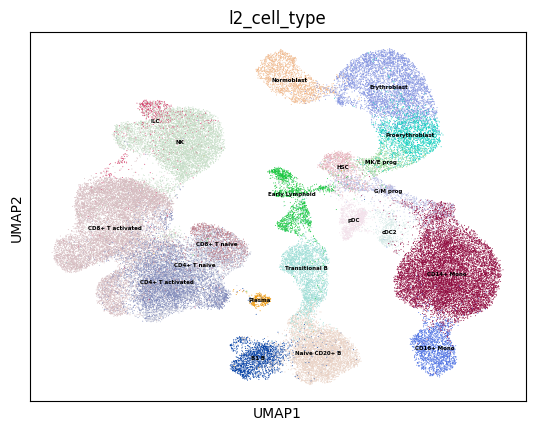

In [5]:
sc.pl.umap(adata, color='l2_cell_type', legend_loc='on data', legend_fontsize=4)

In [151]:
sc.tl.diffmap(adata, n_comps=30)

In [152]:
# remove first diffmap component
adata.obsm['X_diffmap'] = adata.obsm['X_diffmap'][:, 1:]

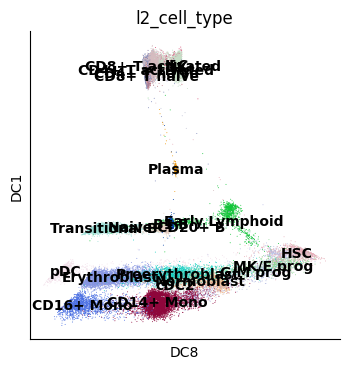

In [153]:
sc.pl.diffmap(adata, color='l2_cell_type', components=['8,1'], legend_loc='on data')

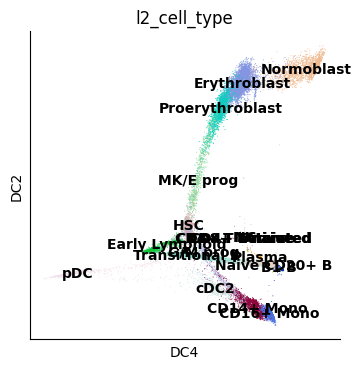

In [154]:
sc.pl.diffmap(adata, color='l2_cell_type', components=['4,2'], legend_loc='on data')

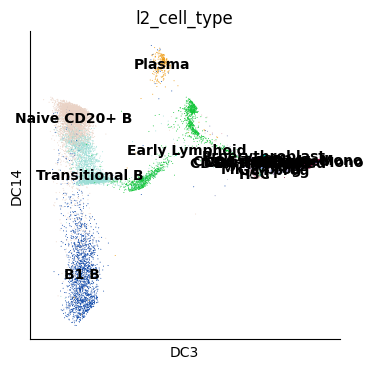

In [155]:
sc.pl.diffmap(adata, color='l2_cell_type', components=['3,14'], legend_loc='on data')

In [156]:
ery =  adata.obs_names[np.argmax(adata.obsm['X_diffmap'][:, 1])]
mono =  adata.obs_names[np.argmin(adata.obsm['X_diffmap'][:, 1])]
b =  adata.obs_names[np.argmin(adata.obsm['X_diffmap'][:, 13])]

In [157]:
# get root
adata.uns['iroot'] = np.argmax(adata.obsm['X_diffmap'][:, 7])

In [158]:
adata.obs['Stem'] = (adata.obs.reset_index().index == adata.uns['iroot']).astype(str)

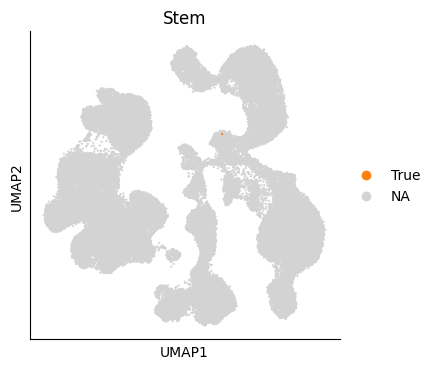

In [159]:
sc.pl.umap(adata, color='Stem', size=10, groups='True')

In [161]:
sc.tl.dpt(adata, n_dcs=29)

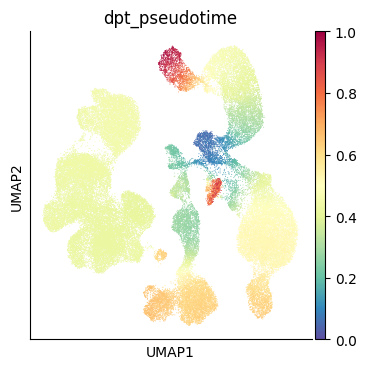

In [201]:
sc.pl.umap(adata_gex, color='dpt_pseudotime')

In [195]:
adata.write(os.path.join(data_path, 'bmmc_multiome_multivi_neurips21_curated_new_palantir_fixed.h5ad'))

## Save adata with only genes

In [197]:
adata_gex = sc.read(os.path.join(data_path, 'bmmc_multiome_multivi_neurips21_curated_new_palantir_fixed.h5ad'))

In [198]:
adata_gex.obs = adata.obs.copy()
adata_gex.write(os.path.join(data_path, 'bmmc_multiome_multivi_neurips21_curated_new_palantir_fixed.h5ad'))

# Run scvi only on the RNA

In [62]:
adata_rna = adata_train[:, adata_train.var.feature_types=='GEX'].copy()

In [64]:
print(adata_rna.shape)
sc.pp.filter_genes(adata_rna, min_cells=int(adata_rna.shape[0] * 0.01))
print(adata_rna.shape)


(63683, 20160)
(63683, 8708)


In [89]:
wandb_logger = WandbLogger(project="neurips", entity='lauradm')

In [90]:
scvi.model.SCVI.setup_anndata(adata_rna, batch_key='batch', layer='counts')

In [91]:
model = scvi.model.SCVI(
    adata_rna,
    n_latent=14,
    n_hidden=217,
    n_layers=2,
    use_layer_norm='both',
    use_batch_norm='none',
    extra_encoder_kwargs={"activation_fn": torch.nn.LeakyReLU},
    
)

In [92]:
model.module

VAE(
  (z_encoder): Encoder(
    (encoder): FCLayers(
      (fc_layers): Sequential(
        (Layer 0): Sequential(
          (0): Linear(in_features=8708, out_features=217, bias=True)
          (1): None
          (2): LayerNorm((217,), eps=1e-05, elementwise_affine=False)
          (3): LeakyReLU(negative_slope=0.01)
          (4): Dropout(p=0.1, inplace=False)
        )
        (Layer 1): Sequential(
          (0): Linear(in_features=217, out_features=217, bias=True)
          (1): None
          (2): LayerNorm((217,), eps=1e-05, elementwise_affine=False)
          (3): LeakyReLU(negative_slope=0.01)
          (4): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (mean_encoder): Linear(in_features=217, out_features=14, bias=True)
    (var_encoder): Linear(in_features=217, out_features=14, bias=True)
  )
  (l_encoder): Encoder(
    (encoder): FCLayers(
      (fc_layers): Sequential(
        (Layer 0): Sequential(
          (0): Linear(in_features=8708, out_features=217, bias

In [93]:
model.train(accelerator='gpu',logger=wandb_logger)

/opt/modules/i12g/anaconda/envs/scvi-tools-1/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/modules/i12g/anaconda/envs/scvi-tools-1/lib/pyt ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/modules/i12g/anaconda/envs/scvi-tools-1/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/modules/i12g/anaconda/envs/scvi-tools-1/lib/pyt ...
You are using a CUDA device ('NVIDIA A40') that has Tensor Cores. To properly utilize them, you should set `torch.set_float3

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/opt/modules/i12g/anaconda/envs/scvi-tools-1/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 126/126: 100%|██████████| 126/126 [09:56<00:00,  4.77s/it, v_num=a1pl, train_loss_step=2.23e+3, train_loss_epoch=2.11e+3]

`Trainer.fit` stopped: `max_epochs=126` reached.


Epoch 126/126: 100%|██████████| 126/126 [09:56<00:00,  4.73s/it, v_num=a1pl, train_loss_step=2.23e+3, train_loss_epoch=2.11e+3]


In [94]:
model.save(os.path.join(data_path, 'scooby_training_data', 'neurips_scvi_rna_only'), save_anndata=True, overwrite=True)

## Create embedding

In [95]:
model = scvi.model.SCVI.load(os.path.join(data_path, 'scooby_training_data', 'neurips_scvi_rna_only'))

INFO     File /s/project/QNA/scborzoi/neurips_bone_marrow/snapatac/anndata/neurips_scvi_rna_only/model.pt already  
         downloaded                                                                                                


/opt/modules/i12g/anaconda/envs/scvi-tools-1/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/modules/i12g/anaconda/envs/scvi-tools-1/lib/pyt ...


In [96]:
X_emb = model.get_latent_representation()

In [97]:
adata_rna.obsm['X_scvi'] = X_emb

In [98]:
sc.pp.neighbors(adata_rna, use_rep='X_scvi')

In [99]:
sc.tl.umap(adata_rna)

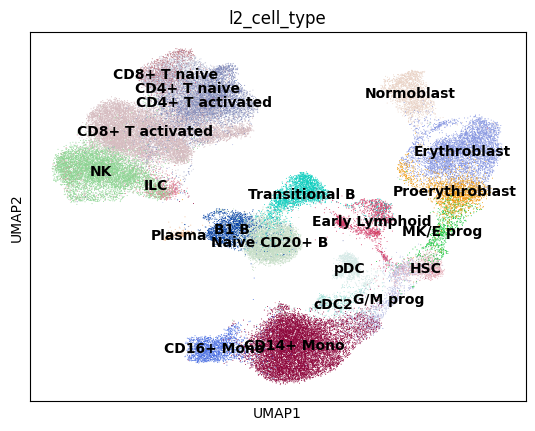

In [100]:
sc.pl.umap(adata_rna, color='l2_cell_type', legend_loc='on data')

In [101]:
embedding = pd.DataFrame({'embedding':list(adata_rna.obsm['X_scvi']), 'obs_names': adata_rna.obs.index})

In [102]:
embedding.to_parquet(os.path.join(data_path, 'scooby_training_data', 'embedding_no_val_genes_rna_only.pq'))

## Run DE gene expression

In [105]:
adata = sc.read(os.path.join(data_path,  'bmmc_multiome_multivi_neurips21_curated_new_palantir_fixed.h5ad'))

In [106]:
adata = adata[:, adata.var.feature_types == "GEX"]

In [107]:
adata.X = adata.layers["counts"].copy()
sc.pp.normalize_total(adata, key_added='size_factor_new')

/opt/modules/i12g/anaconda/envs/scvi-tools-1/lib/python3.12/site-packages/scanpy/preprocessing/_normalization.py:206: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [108]:
sc.pp.log1p(adata)

In [109]:
sc.tl.rank_genes_groups(adata, groupby='l2_cell_type', method='wilcoxon')

/opt/modules/i12g/anaconda/envs/scvi-tools-1/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:429: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "names"] = self.var_names[global_indices]
/opt/modules/i12g/anaconda/envs/scvi-tools-1/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:431: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "scores"] = scores[global_indices]
/opt/modules/i12g/anaconda/envs/scvi-tools-1/lib/python3.12/site-packages/scanpy/tools/_ran

In [33]:
sc.get.rank_genes_groups_df(adata, group='B1 B').head(10)

,names,scores,logfoldchanges,pvals,pvals_adj
0,BANK1,62.923130,4.730576,0.0,0.0
1,RALGPS2,52.592506,3.776884,0.0,0.0
2,CD74,48.529346,2.620639,0.0,0.0
3,OSBPL10,46.252045,4.645995,0.0,0.0
4,MS4A1,42.438168,3.913207,0.0,0.0
5,CDK14,42.125809,3.331959,0.0,0.0
6,AFF3,41.981724,2.525559,0.0,0.0
7,EBF1,41.621998,2.999131,0.0,0.0
8,HLA-DRA,38.963848,2.518634,0.0,0.0
9,ARHGAP24,38.796467,2.801885,0.0,0.0


In [110]:
sc.get.rank_genes_groups_df(adata, group='B1 B').head(10)

,names,scores,logfoldchanges,pvals,pvals_adj
0,BANK1,62.923130,4.730576,0.0,0.0
1,RALGPS2,52.592506,3.776884,0.0,0.0
2,CD74,48.529346,2.620639,0.0,0.0
3,OSBPL10,46.252045,4.645995,0.0,0.0
4,MS4A1,42.438168,3.913207,0.0,0.0
5,CDK14,42.125809,3.331959,0.0,0.0
6,AFF3,41.981724,2.525559,0.0,0.0
7,EBF1,41.621998,2.999131,0.0,0.0
8,HLA-DRA,38.963848,2.518634,0.0,0.0
9,ARHGAP24,38.796467,2.801885,0.0,0.0


In [34]:
adata.write(os.path.join(data_path,  'bmmc_multiome_multivi_neurips21_curated_new_palantir_fixed_GEX.h5ad'))

## Save lineage DE genes for motifs

In [122]:
adata = sc.read(os.path.join(data_path,  'bmmc_multiome_multivi_neurips21_curated_new_palantir_fixed_GEX.h5ad'))

In [126]:
sc.tl.rank_genes_groups(adata, groupby='l1_cell_type', method='wilcoxon')

In [142]:
def get_head_and_tail(adata, ct):
    df = sc.get.rank_genes_groups_df(adata, ct)
    df = df[(np.abs(df['logfoldchanges']) > 2) & (df['pvals_adj'] < 0.01)]
    return df#pd.concat([df.head(100), df.tail(100)])

In [143]:
df = pd.concat([get_head_and_tail(adata, ct) for ct in adata.obs.l1_cell_type.cat.categories])

In [144]:
df = df.drop_duplicates('names')

In [124]:
df.to_csv(os.path.join(data_path, 'scooby_training_data', 'DEG_gene_sequences.csv'), sep='\t', header=None)
df

,0,1,2,3,4
0,chr2,99770619,99967227,AFF3,-
1,chr6,90013413,90210021,BACH2,-
2,chr4,101644744,101841352,BANK1,+
3,chr5,150308180,150504788,CD74,-
4,chr5,158799611,158996219,EBF1,-
...,...,...,...,...,...
3676,chr18,22814070,23010678,RBBP8,+
3677,chr17,56894132,57090740,SCPEP1,+
3678,chr15,59154348,59350956,MYO1E,-
3679,chr8,140731753,140928361,PTK2,-
